In [27]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import random

In [5]:
df = pd.read_pickle("Tank.pkl")
df.timestamp = pd.to_datetime(df.timestamp)
df_new = df.loc[df["CuStepNo ValueY"] != 2]
df_new["Next_Step"] = df_new["CuStepNo ValueY"].shift()
df_steps = df_new.loc[df_new["CuStepNo ValueY"] != df_new["Next_Step"]]

C:\Users\paulh\AppData\Local\Temp\ipykernel_10560\3322347456.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Next_Step"] = df_new["CuStepNo ValueY"].shift()


In [38]:
#px.scatter(df,x="timestamp",y="FIC14002_PV_Out ValueY")


In [39]:
#px.scatter(df,x="timestamp",y="CuStepNo ValueY")

#durchschnittliche zeit

In [6]:
df_steps["Time_next"] = df_steps.timestamp.shift()
df_steps["Diff"] = df_steps.timestamp - df_steps["Time_next"]
df_steps[1:].groupby("Next_Step")["Diff"].mean()

C:\Users\paulh\AppData\Local\Temp\ipykernel_10560\1911402688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steps["Time_next"] = df_steps.timestamp.shift()
C:\Users\paulh\AppData\Local\Temp\ipykernel_10560\1911402688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steps["Diff"] = df_steps.timestamp - df_steps["Time_next"]


Next_Step
1.0   0 days 00:04:15.301526717
3.0   0 days 01:41:23.693486590
7.0   0 days 00:01:11.103053435
8.0   0 days 00:08:56.356321839
Name: Diff, dtype: timedelta64[ns]

In [82]:
df_steps.columns

Index(['timestamp', 'DeviationID ValueY', 'CuStepNo ValueY',
       'LevelMainTank ValueY', 'YC10001_MV ValueY', 'PI12002_PV_Out ValueY',
       'PI12003_PV_Out ValueY', 'YC14001_MV ValueY', 'FIC14002_MV ValueY',
       'FIC14002_PV_Out ValueY', 'FIC14002_SP ValueY', 'YC14006_MV ValueY',
       'PI14012_PV_Out ValueY', 'YC23001_MV ValueY', 'YC22001_MV ValueY',
       'YC21001_MV ValueY', 'FIC23002_PV_Out ValueY', 'FIC23002_MV ValueY',
       'FIC23002_SP ValueY', 'FIC22002_MV ValueY', 'FIC22002_PV_Out ValueY',
       'FIC22002_SP ValueY', 'FIC21002_MV ValueY', 'FIC21002_PV_Out ValueY',
       'FIC21002_SP ValueY', 'YS23004_Ctrl ValueY', 'YS22004_Ctrl ValueY',
       'YS21004_Ctrl ValueY', 'LIC23002_MV ValueY', 'LIC23002_PV_Out ValueY',
       'LIC23002_SP ValueY', 'LIC22002_MV ValueY', 'LIC22002_PV_Out ValueY',
       'LIC22002_SP ValueY', 'LIC21002_MV ValueY', 'LIC21002_PV_Out ValueY',
       'LIC21002_SP ValueY', 'PIC14007_MV ValueY', 'PIC14007_PV_Out ValueY',
       'PIC14007_SP Val

In [ ]:
df_steps[1:].groupby("Next_Step")["time"].mean()

In [8]:
df_steps["time_since_start"] = 0
steps = df_steps.timestamp.unique()
for i in range(len(steps)-1):
    df_steps.loc[df_steps.timestamp == steps[i],"time_since_start"] = (df_new.loc[(df_new.timestamp >= steps[i])&(df_new.timestamp < steps[i+1])].timestamp -steps[i]).max()

C:\Users\paulh\AppData\Local\Temp\ipykernel_10560\1740335311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steps["time_since_start"] = 0
C:\Users\paulh\AppData\Local\Temp\ipykernel_10560\1740335311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steps.loc[df_steps.timestamp == steps[i],"time_since_start"] = (df_new.loc[(df_new.timestamp >= steps[i])&(df_new.timestamp < steps[i+1])].timestamp -steps[i]).max()


In [12]:
#replace all the 0s in time_since_start with the timedelta 0
df_steps.loc[df_steps.time_since_start == 0,"time_since_start"] = datetime.timedelta(0)

df_steps[:].groupby("Next_Step")["time_since_start"].mean()

Next_Step
1.0    0 days 00:01:10.103053435
3.0    0 days 00:04:14.329501915
7.0    0 days 00:08:53.312977099
8.0    0 days 00:03:16.417624521
Name: time_since_start, dtype: object

In [15]:
df_steps

,timestamp,DeviationID ValueY,CuStepNo ValueY,LevelMainTank ValueY,YC10001_MV ValueY,PI12002_PV_Out ValueY,PI12003_PV_Out ValueY,YC14001_MV ValueY,FIC14002_MV ValueY,FIC14002_PV_Out ValueY,...,LIC21002_SP ValueY,PIC14007_MV ValueY,PIC14007_PV_Out ValueY,PIC14007_SP ValueY,YC14008_Ctrl ValueY,PI10003_PV_Out ValueY,Next_Step,Time_next,Diff,time_since_start
0,2018-10-10 14:53:19,1,1,149.985779,100,0.070602,0.087963,100.000000,100.000000,0.000000,...,15,10.000000,0.127008,0.2,0,0.001710,NaN,NaT,NaT,0 days 00:04:07
248,2018-10-10 14:57:27,1,7,136.526093,100,0.063079,1.657986,62.768192,62.778381,1966.041138,...,15,28.206629,0.197753,0.2,0,0.001744,1.0,2018-10-10 14:53:19,0 days 00:04:08,0 days 00:01:12
321,2018-10-10 14:58:40,1,8,141.415466,100,0.059028,1.667824,61.538704,61.544369,1971.671631,...,15,28.761133,0.200745,0.2,0,0.001743,7.0,2018-10-10 14:57:27,0 days 00:01:13,0 days 00:08:52
854,2018-10-10 15:07:33,1,3,116.065994,100,0.058449,2.084491,66.077324,66.801804,1444.403442,...,15,22.631739,0.208638,0.2,0,0.001731,8.0,2018-10-10 14:58:40,0 days 00:08:53,0 days 00:03:17
1052,2018-10-11 10:21:45,4,1,152.251556,100,0.075810,0.089699,100.000000,100.000000,0.000000,...,15,10.000000,0.116767,0.2,0,0.001709,3.0,2018-10-10 15:07:33,0 days 19:14:12,0 days 00:04:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275911,2018-10-31 14:17:14,9,8,89.829849,100,0.055556,1.661458,62.184528,62.187527,1994.004883,...,15,28.974337,0.207777,0.2,0,0.001743,7.0,2018-10-31 14:16:03,0 days 00:01:11,0 days 00:08:56
276448,2018-10-31 14:26:11,9,3,65.929871,100,0.048032,1.863426,62.581421,62.581421,1947.954956,...,15,22.125351,0.193050,0.2,0,0.001734,8.0,2018-10-31 14:17:14,0 days 00:08:57,0 days 00:03:19
276648,2018-10-31 14:29:32,9,1,98.579819,100,0.063657,0.080440,100.000000,100.000000,0.000000,...,15,10.000000,0.111445,0.2,0,0.001679,3.0,2018-10-31 14:26:11,0 days 00:03:21,0 days 00:05:04
276953,2018-10-31 14:34:37,9,7,85.071869,100,0.050926,1.649884,61.568264,61.568264,1964.300537,...,15,26.333004,0.194102,0.2,0,0.001651,1.0,2018-10-31 14:29:32,0 days 00:05:05,0 days 00:01:12


In [16]:
times = df_steps[df_steps["CuStepNo ValueY"] == 1].timestamp.to_list()
df_test2 = pd.DataFrame(columns=df_new.columns)
df_test2.columns

Index(['timestamp', 'DeviationID ValueY', 'CuStepNo ValueY',
       'LevelMainTank ValueY', 'YC10001_MV ValueY', 'PI12002_PV_Out ValueY',
       'PI12003_PV_Out ValueY', 'YC14001_MV ValueY', 'FIC14002_MV ValueY',
       'FIC14002_PV_Out ValueY', 'FIC14002_SP ValueY', 'YC14006_MV ValueY',
       'PI14012_PV_Out ValueY', 'YC23001_MV ValueY', 'YC22001_MV ValueY',
       'YC21001_MV ValueY', 'FIC23002_PV_Out ValueY', 'FIC23002_MV ValueY',
       'FIC23002_SP ValueY', 'FIC22002_MV ValueY', 'FIC22002_PV_Out ValueY',
       'FIC22002_SP ValueY', 'FIC21002_MV ValueY', 'FIC21002_PV_Out ValueY',
       'FIC21002_SP ValueY', 'YS23004_Ctrl ValueY', 'YS22004_Ctrl ValueY',
       'YS21004_Ctrl ValueY', 'LIC23002_MV ValueY', 'LIC23002_PV_Out ValueY',
       'LIC23002_SP ValueY', 'LIC22002_MV ValueY', 'LIC22002_PV_Out ValueY',
       'LIC22002_SP ValueY', 'LIC21002_MV ValueY', 'LIC21002_PV_Out ValueY',
       'LIC21002_SP ValueY', 'PIC14007_MV ValueY', 'PIC14007_PV_Out ValueY',
       'PIC14007_SP Val

In [17]:
df_steps[:-3]

,timestamp,DeviationID ValueY,CuStepNo ValueY,LevelMainTank ValueY,YC10001_MV ValueY,PI12002_PV_Out ValueY,PI12003_PV_Out ValueY,YC14001_MV ValueY,FIC14002_MV ValueY,FIC14002_PV_Out ValueY,...,LIC21002_SP ValueY,PIC14007_MV ValueY,PIC14007_PV_Out ValueY,PIC14007_SP ValueY,YC14008_Ctrl ValueY,PI10003_PV_Out ValueY,Next_Step,Time_next,Diff,time_since_start
0,2018-10-10 14:53:19,1,1,149.985779,100,0.070602,0.087963,100.000000,100.000000,0.000000,...,15,10.000000,0.127008,0.2,0,0.001710,NaN,NaT,NaT,0 days 00:04:07
248,2018-10-10 14:57:27,1,7,136.526093,100,0.063079,1.657986,62.768192,62.778381,1966.041138,...,15,28.206629,0.197753,0.2,0,0.001744,1.0,2018-10-10 14:53:19,0 days 00:04:08,0 days 00:01:12
321,2018-10-10 14:58:40,1,8,141.415466,100,0.059028,1.667824,61.538704,61.544369,1971.671631,...,15,28.761133,0.200745,0.2,0,0.001743,7.0,2018-10-10 14:57:27,0 days 00:01:13,0 days 00:08:52
854,2018-10-10 15:07:33,1,3,116.065994,100,0.058449,2.084491,66.077324,66.801804,1444.403442,...,15,22.631739,0.208638,0.2,0,0.001731,8.0,2018-10-10 14:58:40,0 days 00:08:53,0 days 00:03:17
1052,2018-10-11 10:21:45,4,1,152.251556,100,0.075810,0.089699,100.000000,100.000000,0.000000,...,15,10.000000,0.116767,0.2,0,0.001709,3.0,2018-10-10 15:07:33,0 days 19:14:12,0 days 00:04:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275338,2018-10-31 14:07:40,9,3,65.749191,100,0.052662,1.929977,69.768890,69.986938,1383.175293,...,15,21.875132,0.195403,0.2,0,0.001765,8.0,2018-10-31 13:58:45,0 days 00:08:55,0 days 00:03:17
275536,2018-10-31 14:10:59,9,1,99.116302,100,0.065972,0.076389,100.000000,100.000000,0.000000,...,15,10.000000,0.112330,0.2,0,0.001769,3.0,2018-10-31 14:07:40,0 days 00:03:19,0 days 00:05:03
275840,2018-10-31 14:16:03,9,7,86.316208,100,0.055556,1.764468,62.380203,62.709000,1888.127563,...,15,27.097742,0.203593,0.2,0,0.001762,1.0,2018-10-31 14:10:59,0 days 00:05:04,0 days 00:01:10
275911,2018-10-31 14:17:14,9,8,89.829849,100,0.055556,1.661458,62.184528,62.187527,1994.004883,...,15,28.974337,0.207777,0.2,0,0.001743,7.0,2018-10-31 14:16:03,0 days 00:01:11,0 days 00:08:56


In [18]:
for i in range(times.__len__()-1):
    df_test1 = df_new.loc[(df_new.timestamp >=times[i])&(df_new.timestamp <times[i+1])].groupby("CuStepNo ValueY",as_index=False,sort=False).mean()
    df_test1["Batch"] = i
    df_test2 = pd.concat([df_test2,df_test1])

In [24]:
df_test2["time_since_start"] = df_steps[:-3].time_since_start.values

In [25]:
df_test2

,timestamp,DeviationID ValueY,CuStepNo ValueY,LevelMainTank ValueY,YC10001_MV ValueY,PI12002_PV_Out ValueY,PI12003_PV_Out ValueY,YC14001_MV ValueY,FIC14002_MV ValueY,FIC14002_PV_Out ValueY,...,LIC21002_PV_Out ValueY,LIC21002_SP ValueY,PIC14007_MV ValueY,PIC14007_PV_Out ValueY,PIC14007_SP ValueY,YC14008_Ctrl ValueY,PI10003_PV_Out ValueY,Next_Step,Batch,time_since_start
0,NaN,1.0,1,143.325596,100.0,0.064497,1.596452,74.971991,74.960272,1928.678075,...,7.860605,15.0,26.784184,0.203986,0.2,0.0,0.001735,1.0,0.0,0 days 00:04:07
1,NaN,1.0,7,138.264533,100.0,0.063412,1.638033,61.844759,61.839022,2003.630127,...,7.327218,15.0,28.956889,0.200543,0.2,0.0,0.001753,6.917808,0.0,0 days 00:01:12
2,NaN,1.0,8,125.811046,100.0,0.058851,1.633885,61.447127,61.446802,1999.041225,...,10.140591,15.0,22.19023,0.198639,0.2,0.0,0.001731,7.998124,0.0,0 days 00:08:52
3,NaN,1.0,3,137.822261,100.0,0.067457,0.177095,99.186257,99.20213,59.363122,...,5.513165,15.0,11.107584,0.113143,0.2,0.0,0.001797,3.025253,0.0,0 days 00:03:17
0,NaN,4.0,1,143.723035,100.0,0.07254,2.75502,35.386997,35.359601,1982.813227,...,7.962883,15.0,26.632608,0.20318,0.2,0.0,0.0017,1.008032,1.0,0 days 00:04:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,NaN,9.0,3,87.939399,100.0,0.061588,0.151185,99.425066,99.438855,46.422369,...,5.363418,15.0,10.952062,0.116409,0.2,0.0,0.001762,3.025253,259.0,0 days 00:03:17
0,NaN,9.0,1,92.642519,100.0,0.056382,1.609598,71.657941,71.645104,1944.71444,...,7.392297,15.0,25.904307,0.202166,0.2,0.0,0.001716,1.006579,260.0,0 days 00:05:03
1,NaN,9.0,7,86.714657,100.0,0.054431,1.646828,63.207341,63.211702,1998.336496,...,7.392508,15.0,28.740085,0.202634,0.2,0.0,0.001745,6.915493,260.0,0 days 00:01:10
2,NaN,9.0,8,74.960493,100.0,0.048674,1.642012,60.54188,60.541048,1999.833614,...,10.141812,15.0,22.154647,0.198711,0.2,0.0,0.001717,7.998138,260.0,0 days 00:08:56


In [15]:
df_test1 = df_new.loc[(df_new.timestamp >=times[261])].groupby("CuStepNo ValueY",as_index=False,sort=False).mean()

In [16]:
df_test1

,CuStepNo ValueY,DeviationID ValueY,LevelMainTank ValueY,YC10001_MV ValueY,PI12002_PV_Out ValueY,PI12003_PV_Out ValueY,YC14001_MV ValueY,FIC14002_MV ValueY,FIC14002_PV_Out ValueY,FIC14002_SP ValueY,...,LIC22002_SP ValueY,LIC21002_MV ValueY,LIC21002_PV_Out ValueY,LIC21002_SP ValueY,PIC14007_MV ValueY,PIC14007_PV_Out ValueY,PIC14007_SP ValueY,YC14008_Ctrl ValueY,PI10003_PV_Out ValueY,Next_Step
0,1,9.0,92.175512,100.0,0.055533,1.609643,71.420559,71.423973,1944.988486,2000.0,...,2.0,356.324341,7.399370,15.0,25.786605,0.201865,0.2,0.0,0.001703,1.006557
1,7,9.0,85.980759,100.0,0.053209,1.646182,62.821513,62.821513,1999.754301,2000.0,...,2.0,23.694151,7.376782,15.0,28.663271,0.202904,0.2,0.0,0.001716,6.917808
2,8,9.0,84.054268,100.0,-0.103924,1.305145,38.956304,38.957532,1838.391751,2000.0,...,2.0,729.245997,9.737094,15.0,11.966983,0.125792,0.2,0.0,-0.035633,7.999318


In [26]:
#check for missing values
df_test2.isnull().sum()


timestamp                 1044
DeviationID ValueY           0
CuStepNo ValueY              0
LevelMainTank ValueY         0
YC10001_MV ValueY            0
PI12002_PV_Out ValueY        0
PI12003_PV_Out ValueY        0
YC14001_MV ValueY            0
FIC14002_MV ValueY           0
FIC14002_PV_Out ValueY       0
FIC14002_SP ValueY           0
YC14006_MV ValueY            0
PI14012_PV_Out ValueY        0
YC23001_MV ValueY            0
YC22001_MV ValueY            0
YC21001_MV ValueY            0
FIC23002_PV_Out ValueY       0
FIC23002_MV ValueY           0
FIC23002_SP ValueY           0
FIC22002_MV ValueY           0
FIC22002_PV_Out ValueY       0
FIC22002_SP ValueY           0
FIC21002_MV ValueY           0
FIC21002_PV_Out ValueY       0
FIC21002_SP ValueY           0
YS23004_Ctrl ValueY          0
YS22004_Ctrl ValueY          0
YS21004_Ctrl ValueY          0
LIC23002_MV ValueY           0
LIC23002_PV_Out ValueY       0
LIC23002_SP ValueY           0
LIC22002_MV ValueY           0
LIC22002

In [20]:
df_test2["DeviationID ValueY"].value_counts(normalize=True)

1.000000     0.134100
9.000000     0.134100
3.000000     0.095785
5.000000     0.091954
6.000000     0.091954
7.000000     0.091954
8.000000     0.091954
2.000000     0.091954
4.000000     0.088123
10.000000    0.087165
9.916667     0.000958
Name: DeviationID ValueY, dtype: float64

In [21]:
df_test2["DeviationID ValueY"].unique()

array([1.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 2.0, 3.0, 10.0,
       9.916666666666666], dtype=object)

In [22]:
df_test2[df_test2["DeviationID ValueY"] == 9.916666666666666]

,CuStepNo ValueY,DeviationID ValueY,LevelMainTank ValueY,YC10001_MV ValueY,PI12002_PV_Out ValueY,PI12003_PV_Out ValueY,YC14001_MV ValueY,FIC14002_MV ValueY,FIC14002_PV_Out ValueY,FIC14002_SP ValueY,...,LIC21002_MV ValueY,LIC21002_PV_Out ValueY,LIC21002_SP ValueY,PIC14007_MV ValueY,PIC14007_PV_Out ValueY,PIC14007_SP ValueY,YC14008_Ctrl ValueY,PI10003_PV_Out ValueY,Next_Step,Batch
3,3,9.916667,93.313731,100.0,0.052623,0.073167,100.0,100.0,0.0,2000.0,...,2.539063,3.760323,15.0,10.452435,0.119192,0.2,0.0,0.001774,3.041667,238


In [23]:
times[238]

Timestamp('2018-10-30 10:04:54')

In [24]:
times[239]

Timestamp('2018-10-30 11:19:52')

In [25]:
df_new.loc[(df_new.timestamp >=times[238])&(df_new.timestamp <times[239])&(df_new["CuStepNo ValueY"] == 3)]["DeviationID ValueY"].value_counts()

10    119
0       1
Name: DeviationID ValueY, dtype: int64

In [28]:
df_test2.columns

Index(['timestamp', 'DeviationID ValueY', 'CuStepNo ValueY',
       'LevelMainTank ValueY', 'YC10001_MV ValueY', 'PI12002_PV_Out ValueY',
       'PI12003_PV_Out ValueY', 'YC14001_MV ValueY', 'FIC14002_MV ValueY',
       'FIC14002_PV_Out ValueY', 'FIC14002_SP ValueY', 'YC14006_MV ValueY',
       'PI14012_PV_Out ValueY', 'YC23001_MV ValueY', 'YC22001_MV ValueY',
       'YC21001_MV ValueY', 'FIC23002_PV_Out ValueY', 'FIC23002_MV ValueY',
       'FIC23002_SP ValueY', 'FIC22002_MV ValueY', 'FIC22002_PV_Out ValueY',
       'FIC22002_SP ValueY', 'FIC21002_MV ValueY', 'FIC21002_PV_Out ValueY',
       'FIC21002_SP ValueY', 'YS23004_Ctrl ValueY', 'YS22004_Ctrl ValueY',
       'YS21004_Ctrl ValueY', 'LIC23002_MV ValueY', 'LIC23002_PV_Out ValueY',
       'LIC23002_SP ValueY', 'LIC22002_MV ValueY', 'LIC22002_PV_Out ValueY',
       'LIC22002_SP ValueY', 'LIC21002_MV ValueY', 'LIC21002_PV_Out ValueY',
       'LIC21002_SP ValueY', 'PIC14007_MV ValueY', 'PIC14007_PV_Out ValueY',
       'PIC14007_SP Val

Fehler gefunden

Ihn fragen ob wir des umändern sollen

In [33]:
df_test2["time_since_start"] = df_test2["time_since_start"].dt.total_seconds()

In [43]:
#Testset und Featureengineering

#78 random numbers between 0 and 260
randomlist = random.sample(range(0, 260), 78)

df_test = df_test2.loc[df_test2["Batch"].isin(randomlist)]
df_train = df_test2.loc[~df_test2["Batch"].isin(randomlist)]

y_train = df_train["DeviationID ValueY"].astype(int)
y_test = df_test["DeviationID ValueY"].astype(int)
X_train = df_train.drop(["DeviationID ValueY","Batch","Next_Step","timestamp"],axis=1)
X_test = df_test.drop(["DeviationID ValueY","Batch","Next_Step","timestamp"],axis=1)

In [44]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [37]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [28]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'], 'multi_class': ['ovr']}
grid = GridSearchCV(LogisticRegression(solver='saga',max_iter=5000), param_grid, refit = True, verbose = 3,n_jobs=4)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.score(X_test, y_test))



Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\paulh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\paulh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\paulh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



{'C': 1000, 'multi_class': 'ovr', 'penalty': 'l1'}
LogisticRegression(C=1000, max_iter=5000, multi_class='ovr', penalty='l1',
                   solver='saga')
0.7776908023483367
0.7948717948717948


C:\Users\paulh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [29]:
#best parameters
logreg = LogisticRegression(penalty="l1",solver='saga',max_iter=5000,multi_class="multinomial",C=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.83


In [45]:
#mit ovr

logreg = LogisticRegression(penalty="l1",solver='saga',max_iter=10000,multi_class="ovr",C=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


Feature: 0, Score: -0.80656
Feature: 1, Score: 1.90969
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.98375
Feature: 4, Score: -9.40366
Feature: 5, Score: -0.89580
Feature: 6, Score: -1.01452
Feature: 7, Score: 3.41125
Feature: 8, Score: 0.62691
Feature: 9, Score: -1.42113
Feature: 10, Score: -0.74380
Feature: 11, Score: 1.22542
Feature: 12, Score: 0.00000
Feature: 13, Score: -2.15887
Feature: 14, Score: 3.72542
Feature: 15, Score: 1.13421
Feature: 16, Score: -0.49255
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.09605
Feature: 19, Score: -1.21175
Feature: 20, Score: -1.87805
Feature: 21, Score: 0.66907
Feature: 22, Score: -0.45707
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: -0.51832
Feature: 27, Score: 6.32948
Feature: 28, Score: -1.17210
Feature: 29, Score: 1.35882
Feature: 30, Score: -7.51036
Feature: 31, Score: 0.00000
Feature: 32, Score: -0.45652
Feature: 33, Score: 1.50098
Feature: 34, Score: 0.00000
Feature: 35, Sc

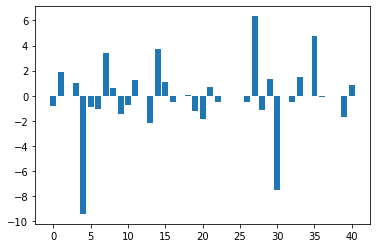

In [50]:
#feature importance
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()



In [31]:
#accuracy for each class
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.79      0.67        24
           2       0.94      1.00      0.97        32
           3       0.93      0.97      0.95        40
           4       0.96      0.92      0.94        24
           5       0.95      0.80      0.86        44
           6       0.52      0.55      0.54        20
           7       0.91      0.75      0.82        28
           8       1.00      1.00      1.00        36
           9       0.71      0.50      0.59        44
          10       0.38      0.60      0.46        20

    accuracy                           0.80       312
   macro avg       0.79      0.79      0.78       312
weighted avg       0.82      0.80      0.80       312



In [32]:
#SVC
from sklearn.svm import SVC


#hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, "scale","auto"],'decision_function_shape':["ovo","ovr"],'kernel':["poly","rbf","sigmoid"]}
grid = GridSearchCV(SVC(cache_size=400), param_grid, refit = True, verbose = 3,n_jobs=4)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.score(X_test, y_test))


Fitting 5 folds for each of 168 candidates, totalling 840 fits
{'C': 1000, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}
SVC(C=1000, cache_size=400, decision_function_shape='ovo')
0.7707948932997857
0.842948717948718


In [46]:
#best parameters
from sklearn.svm import SVC
svc = SVC(kernel='rbf',C=1000,decision_function_shape="ovr",cache_size=400)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('Accuracy of SVC classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))

Accuracy of SVC classifier on test set: 0.88


In [47]:

#accuracy for each class
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.93      0.84        28
           2       0.94      0.94      0.94        36
           3       1.00      0.96      0.98        24
           4       0.97      0.97      0.97        32
           5       0.89      0.86      0.87        28
           6       0.96      0.72      0.83        36
           7       0.82      0.89      0.85        36
           8       1.00      1.00      1.00        32
           9       0.68      0.90      0.78        29
          10       0.83      0.65      0.73        31

    accuracy                           0.88       312
   macro avg       0.89      0.88      0.88       312
weighted avg       0.89      0.88      0.88       312



In [35]:

# import datetime
# import matplotlib.pyplot as plt

# # import data to data frame
# n=datetime.datetime.now()
# df=pd.read_csv('SmA-Four-Tank-Batch-Process_V2.csv',delimiter=';')
# n2=datetime.datetime.now()

# # print first lines of data frame
# print(df.head())
# # print data types
# print(df.dtypes)
# # timestamp is an object, not a timestamp
# df['timestamp']=pd.to_datetime(df['timestamp'],format='%Y-%m-%dT%H:%M:%S.%f')

# print('Nach Umwandlung in ein Datumsformat:')
# print('Erster Zeitstempel: {}'.format(df.at[1,'timestamp']))
# print('Differenz der Zeitstempel: {}'.format(df['timestamp'].diff()))
# print('Format des Zeitstempels: {}'.format(df['timestamp'].dtype))
# # save data frame as pickle - more efficient
# df.to_pickle('SmA-Four-Tank-Batch-Process_V2.pkl')
# # read data frame from pickle
# n3=datetime.datetime.now()
# df=pd.read_pickle('SmA-Four-Tank-Batch-Process_V2.pkl')
# n4=datetime.datetime.now()

# print('Time to read data into data frame from csv: {}'.format(n2-n))
# print('Time to read data into data frame from pickle: {}'.format(n4-n3))
# # print columns of data frame
# print(df.columns)
# # plot column FIC14002_PV_Out ValueY (flow rate)
# plt.subplot(121)
# plt.plot(df['timestamp'],df['FIC14002_PV_Out ValueY'])
# plt.ylabel('mass flow of F14002 / (kg/h)')
# plt.xlabel('date')
# # plot step number
# plt.subplot(122)
# plt.plot(df['timestamp'],df['CuStepNo ValueY'])
# plt.ylabel('step number')
# plt.xlabel('date')
# plt.show()
# # filter dataframe by step 1
# df1=df[df['CuStepNo ValueY']==1]
# print(df.describe())
# print(df1.describe())
# print('Shape of df (all steps): {}'.format(df.shape))
# print('Shape of df1 (step 1): {}'.format(df1.shape))

In [36]:
# import pandas as pd
# # read data frame from pickle
# df=pd.read_pickle('SmA-Four-Tank-Batch-Process_V2.pkl')
# # remove steps data are not mentioned in the documentation
# vsteps=[1,7,8,3]
# df=df[df['CuStepNo ValueY'].isin(vsteps)]
# # determine start and end of steps
# df['dstep_p']=df['CuStepNo ValueY'].diff()
# df['dstep_n']=df['CuStepNo ValueY'].diff(-1)
# # select rows with a step change
# dfsen=df[(df['dstep_n']!=0)]
# dfsep=df[(df['dstep_p']!=0)]
# dfse=pd.concat([dfsen,dfsep])
# dfse=dfse.sort_values(by=['timestamp'])
# # create new dataframe where we store extracted information
# dfinfo_steps=pd.DataFrame(columns=['step_length','start','end','stepn'])
# # iterative approach
# pstep=-1
# c=0
# for n in range(dfse.shape[0]):
#     # get row
#     r=dfse.iloc[n]
#     if pstep==r['CuStepNo ValueY']:
#         # determine step length
#         stepl=r['timestamp']-dfse.iloc[n-1]['timestamp']
#         # update dataframe
#         dfinfo_steps.loc[c]=(stepl,dfse.iloc[n-1]['timestamp'],r['timestamp'],r['CuStepNo ValueY'])
#         c=c+1
#     else:
#         pstep=r['CuStepNo ValueY']
# print(dfinfo_steps.head())
# print('Max step_length: {}'.format(dfinfo_steps['step_length'].max()))
# print('Min step_length: {}'.format(dfinfo_steps['step_length'].min()))
# print('#steps: {}'.format(dfinfo_steps.shape[0]))
# # now determine whether the batch is complete
# batchn=1
# batchi=-1
# dfinfo_steps["batchn"]=0
# dfinfo_steps["is_complete"]=False
# dfinfo_batches=pd.DataFrame(columns=['batch_length','start','end','steps','batchn','is_complete'])
# n=0
# b=0
# while True:
#     if n+len(vsteps)>dfinfo_steps.shape[0]:
#         # complete info at incomplete, last batch
#         steps=[]
#         for v in range(dfinfo_steps.shape[0]-n):
#             dfinfo_steps.at[n+v,'batchn']=batchi
#             dfinfo_steps.at[n+v,'is_complete']=False
#             steps.append(dfinfo_steps.at[n+v,'stepn'])
#         dfinfo_batches.loc[b]=[dfinfo_steps.at[n+v,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
#                                dfinfo_steps.at[n+v,'end'],steps,batchi,False]
#         b=b+1
#         break
#     # check if all steps of a batch are present and in correct order
#     isCorrect=True
#     for v in range(len(vsteps)):
#         isCorrect=dfinfo_steps.loc[n+v,'stepn']==vsteps[v]
#         if not isCorrect:
#             break
#     if isCorrect:
#         steps=[]
#         for v in range(len(vsteps)):
#             dfinfo_steps.at[n+v,'batchn']=batchn
#             dfinfo_steps.at[n+v,'is_complete']=True
#             steps.append(dfinfo_steps.at[n+v,'stepn'])
#         dfinfo_batches.loc[b]=[dfinfo_steps.at[n+v,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
#                                dfinfo_steps.at[n+v,'end'],steps,batchn,True]
#         n=n+len(vsteps)
#         batchn=batchn+1
#         b=b+1
#     else:
#         steps=[]
#         for vc in range(v):
#             dfinfo_steps.at[n+vc,'batchn']=batchi
#             dfinfo_steps.at[n+vc,'is_complete']=False
#             steps.append(dfinfo_steps.at[n+v,'stepn'])
#         dfinfo_batches.loc[b]=[dfinfo_steps.at[n+vc,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
#                                dfinfo_steps.at[n+vc,'end'],steps,batchi,False]
#         batchi=batchi-1
#         n=n+vc
#         b=b+1
# # save dfinfo_steps to file
# dfinfo_steps.to_pickle('SmA-Four-Tank-Info-Steps.pkl')
# dfinfo_batches.to_pickle('SmA-Four-Tank-Info-Batches.pkl')

In [37]:
# import pandas as pd
# dfinfo_steps=pd.read_pickle('SmA-Four-Tank-Info-Steps.pkl')
# dfinfo_batches=pd.read_pickle('SmA-Four-Tank-Info-Batches.pkl')
# print('#complete batches: {}'.format(dfinfo_steps['batchn'].max()))
# print('#incomplete batches: {}'.format(abs(dfinfo_steps['batchn'].min())))
# print('step#\tshortest\tlongest')
# for v in set(dfinfo_steps['stepn']):
#     tmp=dfinfo_steps[dfinfo_steps['stepn']==v]
#     print('{}\t{}\t\t{}'.format(v,tmp['step_length'].min().total_seconds(),tmp['step_length'].max().total_seconds()))
# print('Longest batch: {}'.format(dfinfo_batches['batch_length'].max()))
# print('Shortest batch: {}'.format(dfinfo_batches['batch_length'].min()))
